# Cell-Cell Communication Analysis
Infer ligand-receptor interactions between spatially proximal cell types. Map signaling pathways active at tumor-immune interfaces and identify therapeutic targets.

In [1]:
# IMPORTS & PATHS 

from __future__ import annotations
from pathlib import Path
import warnings, os, tempfile
warnings.filterwarnings('ignore')
os.environ.setdefault('NUMBA_CACHE_DIR',
    str(Path(tempfile.gettempdir()) / 'numba_cache'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from itertools import combinations
import scanpy as sc
import squidpy as sq

rcParams['font.family'] = 'DejaVu Sans'
sc.settings.verbosity  = 3

cwd = Path.cwd().resolve()
if (cwd / 'README.md').exists() and (cwd / 'data').exists():
    project_root = cwd
elif (cwd.parent / 'README.md').exists():
    project_root = cwd.parent
else:
    raise RuntimeError(f'Cannot locate project root from cwd={cwd}.')

processed_dir = project_root / 'data' / 'processed'
fig_cc_dir    = project_root / 'figures' / 'cellcomm'
fig_cc_dir.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = str(fig_cc_dir)

print(f"Scanpy  : {sc.__version__}")
print(f"Squidpy : {sq.__version__}")

Scanpy  : 1.12
Squidpy : 1.8.1


In [ ]:
# LOAD ADATA
adata = sc.read_h5ad(processed_dir / 'adata_scored.h5ad')

print(adata)
print(f"\nSpots      : {adata.n_obs:,}")
print(f"Genes      : {adata.n_vars:,}")
print(f"Cell types : {adata.obs['cell_type'].nunique()}")
print(f"\nCell type counts:")
print(adata.obs['cell_type'].value_counts())

AnnData object with n_obs × n_vars = 4869 × 21349
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'leiden_0.3', 'leiden_0.5', 'leiden_0.6', 'leiden_1.0', 'leiden', 'cell_type', 'score_Tumor_Epithelial', 'score_Luminal_A', 'score_HER2_Enriched', 'score_Basal_Like', 'score_Proliferating', 'score_CAFs', 'score_Myofibroblasts', 'score_Endothelial', 'score_Adipocytes', 'score_T_Cells', 'score_CD8_T_Cells', 'score_CD4_T_Cells', 'score_Tregs', 'score_B_Cells', 'score_Plasma_Cells', 'score_Macrophages_M1', 'score_Macrophages_M2', 'score_NK_Cells', 'score_Mast_Cells', 'score_Dendritic_Cells', 'score_TLS_signature', 'score_Hypoxia', 'score_EMT', 'score_Exhausted_T'
    var:

In [3]:
# DEFINE LR PAIRS — COMPLETE TME 
# Manually curated ligand-receptor pairs
# Covering all major TME signaling axes
# Source: CellChatDB + NicheNet + literature

lr_pairs = {
    # ── Immune Checkpoint (Tumor → Immune) ───────────────
    'PD-L1 → PD-1'        : ('CD274',  'PDCD1'),
    'CD80 → CTLA4'        : ('CD80',   'CTLA4'),
    'CD86 → CTLA4'        : ('CD86',   'CTLA4'),
    'TIGIT → CD155'       : ('TIGIT',  'PVR'),
    'LAG3 → MHC-II'       : ('LAG3',   'HLA-DRA'),

    # ── TGF-β Axis (CAF → Tumor/Immune) ──────────────────
    'TGFβ1 → TGFBR1'     : ('TGFB1',  'TGFBR1'),
    'TGFβ1 → TGFBR2'     : ('TGFB1',  'TGFBR2'),
    'TGFβ2 → TGFBR2'     : ('TGFB2',  'TGFBR2'),

    # ── VEGF / Angiogenesis (Tumor → Endothelial) ────────
    'VEGFA → KDR'         : ('VEGFA',  'KDR'),
    'VEGFA → FLT1'        : ('VEGFA',  'FLT1'),
    'VEGFC → FLT4'        : ('VEGFC',  'FLT4'),

    # ── Immune Recruitment Chemokines ────────────────────
    'CXCL9 → CXCR3'      : ('CXCL9',  'CXCR3'),
    'CXCL10 → CXCR3'     : ('CXCL10', 'CXCR3'),
    'CXCL12 → CXCR4'     : ('CXCL12', 'CXCR4'),
    'CXCL13 → CXCR5'     : ('CXCL13', 'CXCR5'),
    'CCL2 → CCR2'         : ('CCL2',   'CCR2'),
    'CCL5 → CCR5'         : ('CCL5',   'CCR5'),
    'CCL19 → CCR7'        : ('CCL19',  'CCR7'),

    # ── TNF / Inflammatory ───────────────────────────────
    'TNF → TNFRSF1A'      : ('TNF',    'TNFRSF1A'),
    'FASL → FAS'          : ('FASLG',  'FAS'),
    'TRAIL → DR4'         : ('TNFSF10','TNFRSF10A'),

    # ── Notch (Stroma → Tumor) ───────────────────────────
    'JAG1 → NOTCH1'       : ('JAG1',   'NOTCH1'),
    'JAG1 → NOTCH2'       : ('JAG1',   'NOTCH2'),
    'DLL4 → NOTCH1'       : ('DLL4',   'NOTCH1'),

    # ── WNT (Tumor autocrine) ─────────────────────────────
    'WNT5A → FZD1'        : ('WNT5A',  'FZD1'),
    'WNT5A → ROR2'        : ('WNT5A',  'ROR2'),

    # ── EGF / HER2 (Tumor autocrine) ─────────────────────
    'EGF → EGFR'          : ('EGF',    'EGFR'),
    'EREG → EGFR'         : ('EREG',   'EGFR'),
    'NRG1 → ERBB3'        : ('NRG1',   'ERBB3'),

    # ── ECM / Adhesion (CAF → Tumor) ─────────────────────
    'FN1 → ITGA5'         : ('FN1',    'ITGA5'),
    'FN1 → ITGB1'         : ('FN1',    'ITGB1'),
    'COL1A1 → ITGA1'      : ('COL1A1', 'ITGA1'),
    'POSTN → ITGAV'       : ('POSTN',  'ITGAV'),

    # ── IL signaling (Immune → Tumor) ────────────────────
    'IL6 → IL6R'          : ('IL6',    'IL6R'),
    'IL10 → IL10RA'       : ('IL10',   'IL10RA'),
    'IL1B → IL1R1'        : ('IL1B',   'IL1R1'),
    'IFNG → IFNGR1'       : ('IFNG',   'IFNGR1'),

    # ── MHC / Antigen Presentation ───────────────────────
    'HLA-A → CD8A'        : ('HLA-A',  'CD8A'),
    'HLA-DRA → CD4'       : ('HLA-DRA','CD4'),
}

print(f"Total LR pairs defined : {len(lr_pairs)}")
print(f"\nGene availability:")
available, missing = [], []
for name, (lig, rec) in lr_pairs.items():
    l_ok = lig in adata.var_names
    r_ok = rec in adata.var_names
    if l_ok and r_ok:
        available.append(name)
    else:
        missing.append(f"{name}  ({'L missing' if not l_ok else 'R missing'})")

print(f"  Available : {len(available)}")
print(f"  Missing   : {len(missing)}")
if missing:
    for m in missing:
        print(f"    !  {m}")

Total LR pairs defined : 39

Gene availability:
  Available : 39
  Missing   : 0


In [4]:
# COMPUTE LR CO-EXPRESSION SCORES
# For each LR pair compute geometric mean of
# ligand × receptor expression per spot
# Then average per cluster pair

print("Computing LR co-expression scores...")

results = []

for name, (lig, rec) in lr_pairs.items():
    if lig not in adata.var_names or rec not in adata.var_names:
        continue

    # Get expression from raw log-normalized counts
    lig_expr = np.array(adata.raw[:, lig].X.todense()).flatten() \
               if hasattr(adata.raw.X, 'todense') \
               else adata.raw[:, lig].X.flatten()
    rec_expr = np.array(adata.raw[:, rec].X.todense()).flatten() \
               if hasattr(adata.raw.X, 'todense') \
               else adata.raw[:, rec].X.flatten()

    # Geometric mean co-expression score per spot
    lr_score = np.sqrt(lig_expr * rec_expr)
    adata.obs[f'lr_{name}'] = lr_score

    # Mean per cluster
    for ct in adata.obs['cell_type'].unique():
        mask = adata.obs['cell_type'] == ct
        score = lr_score[mask.values].mean()
        results.append({
            'LR_pair'   : name,
            'Ligand'    : lig,
            'Receptor'  : rec,
            'Cell_type' : ct,
            'Score'     : score
        })

lr_df = pd.DataFrame(results)
print(f"   Computed {len(available)} LR pair scores")
print(f"   Results shape : {lr_df.shape}")
print(f"\nTop 10 LR interactions by mean score:")
top10 = lr_df.groupby('LR_pair')['Score'].mean()\
             .sort_values(ascending=False).head(10)
print(top10.round(4))

Computing LR co-expression scores...
   Computed 39 LR pair scores
   Results shape : (351, 5)

Top 10 LR interactions by mean score:
LR_pair
FN1 → ITGB1       2.6934
FN1 → ITGA5       0.9400
HLA-DRA → CD4     0.8799
POSTN → ITGAV     0.6559
COL1A1 → ITGA1    0.4527
LAG3 → MHC-II     0.4447
HLA-A → CD8A      0.3334
CXCL12 → CXCR4    0.2690
TGFβ1 → TGFBR2    0.1563
TGFβ1 → TGFBR1    0.1468
Name: Score, dtype: float32


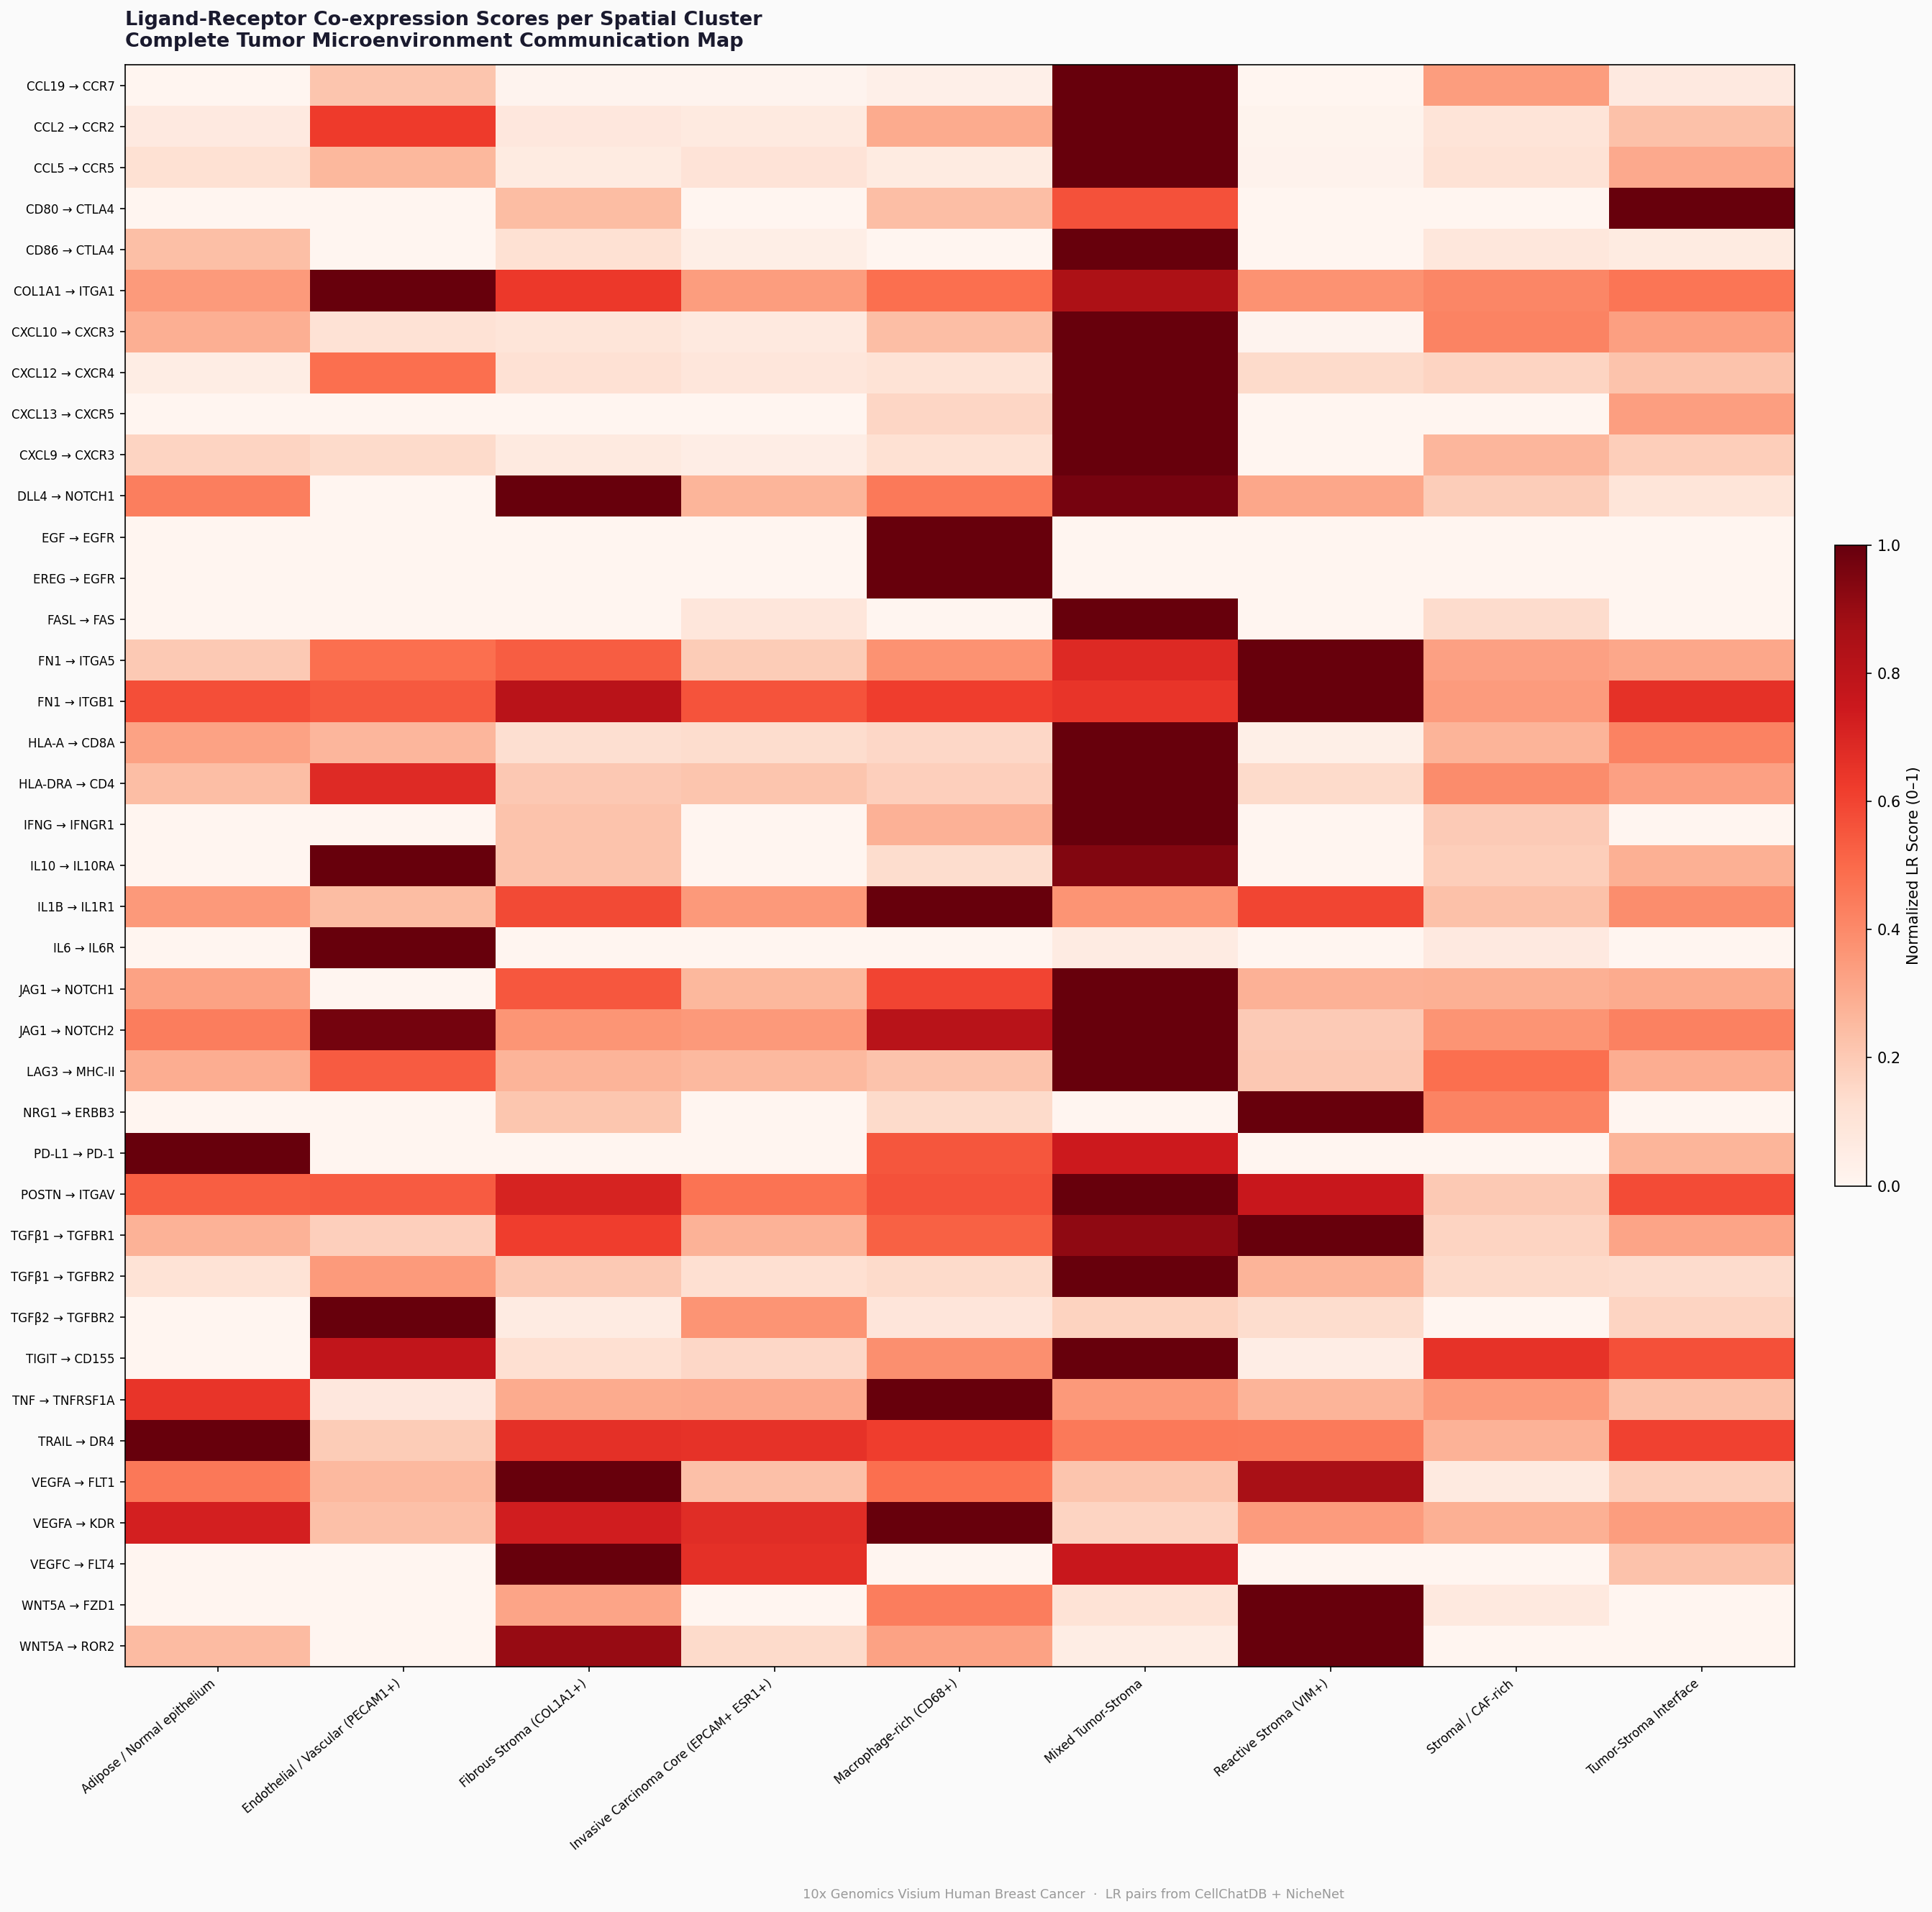

Saved C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\cellcomm\01_LR_heatmap_full.png


In [6]:
# LR HEATMAP — ALL PAIRS × ALL CLUSTERS
lr_matrix = lr_df.pivot_table(
    index='LR_pair',
    columns='Cell_type',
    values='Score',
    aggfunc='mean'
)

# Normalize per row 0-1
lr_norm = lr_matrix.div(lr_matrix.max(axis=1) + 1e-9, axis=0)

fig, ax = plt.subplots(figsize=(20, 18), dpi=150)
fig.patch.set_facecolor('#FAFAFA')

im = ax.imshow(lr_norm.values, aspect='auto',
               cmap='Reds', vmin=0, vmax=1)

ax.set_xticks(range(len(lr_norm.columns)))
ax.set_xticklabels(lr_norm.columns,
                   rotation=40, ha='right', fontsize=8)
ax.set_yticks(range(len(lr_norm.index)))
ax.set_yticklabels(lr_norm.index, fontsize=8)

plt.colorbar(im, ax=ax, shrink=0.4,
             pad=0.02, label='Normalized LR Score (0–1)')

ax.set_title(
    'Ligand-Receptor Co-expression Scores per Spatial Cluster\n'
    'Complete Tumor Microenvironment Communication Map',
    fontsize=13, fontweight='bold',
    loc='left', color='#1a1a2e', pad=12
)

fig.suptitle(
    '10x Genomics Visium Human Breast Cancer  ·  '
    'LR pairs from CellChatDB + NicheNet',
    fontsize=8.5, color='#999999', y=0.01
)

plt.tight_layout(rect=[0, 0.02, 1, 1])
out = fig_cc_dir / '01_LR_heatmap_full.png'
plt.savefig(out, dpi=200, bbox_inches='tight', facecolor='#FAFAFA')
plt.show()
print(f"Saved {out}") 

Saved figures/cellcomm/03_checkpoint_spatial.png

 Check if PD-L1/PD-1 overlaps with immune exclusion zone!


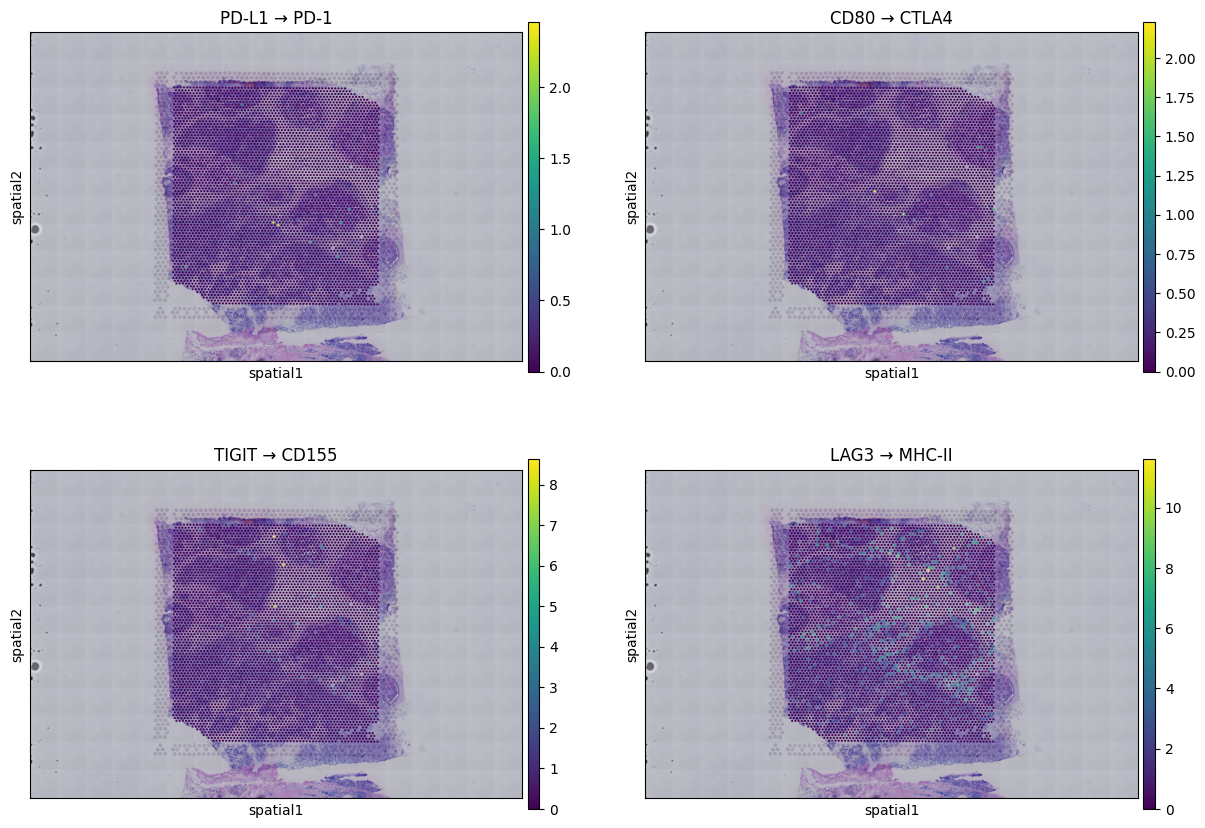

In [9]:
# CHECKPOINT AXIS SPATIAL MAP
# PD-L1/PD-1 + CTLA4 axis — immune evasion

checkpoint_pairs = [
    'PD-L1 → PD-1',
    'CD80 → CTLA4',
    'TIGIT → CD155',
    'LAG3 → MHC-II',
]
checkpoint_cols = [f'lr_{p}' for p in checkpoint_pairs
                   if f'lr_{p}' in adata.obs.columns]

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_cc_dir)

sq.pl.spatial_scatter(
    adata,
    color=checkpoint_cols,
    ncols=2,
    use_raw=False,
    title=checkpoint_pairs[:len(checkpoint_cols)],
    save='_03_checkpoint_spatial.png'
)

sc.settings.figdir = prev_figdir
print("Saved figures/cellcomm/03_checkpoint_spatial.png")
print("\n Check if PD-L1/PD-1 overlaps with immune exclusion zone!")

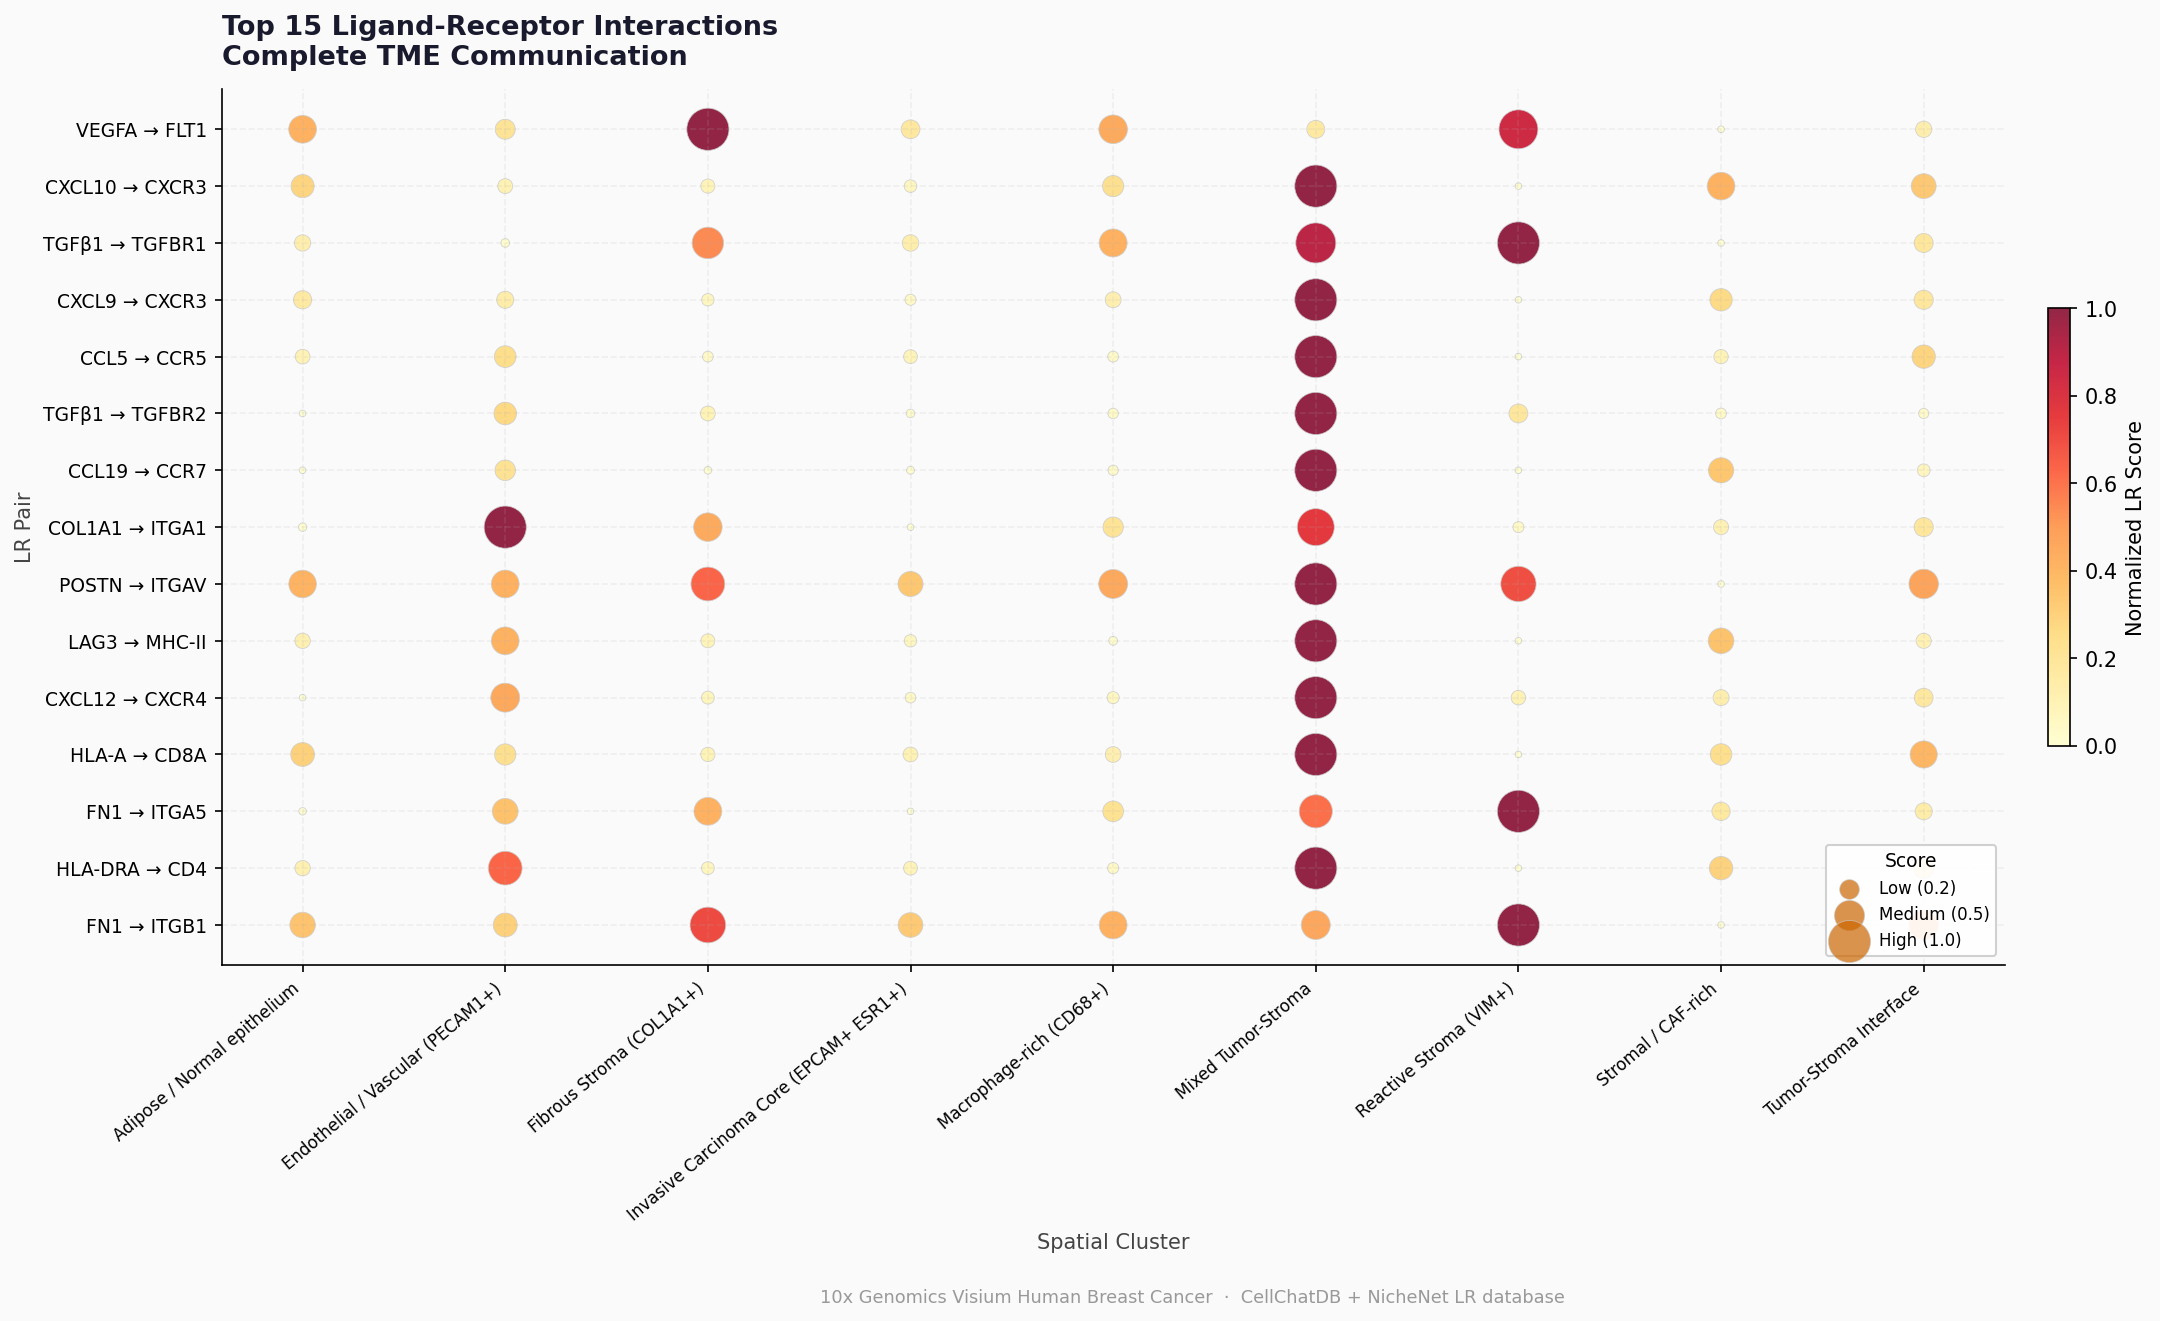

Saved C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\cellcomm\04_LR_bubble_pub.png


In [10]:
# BUBBLE PLOT — TOP LR INTERACTIONS
# Publication-style bubble plot
# X = cell type, Y = LR pair, size = score, color = score

# Get top 15 LR pairs by variance across clusters
top_pairs = lr_matrix.var(axis=1)\
                     .sort_values(ascending=False)\
                     .head(15).index.tolist()

plot_df = lr_df[lr_df['LR_pair'].isin(top_pairs)].copy()

# Normalize scores 0-1 per pair
plot_df['Score_norm'] = plot_df.groupby('LR_pair')['Score']\
    .transform(lambda x: (x - x.min()) /
               (x.max() - x.min() + 1e-9))

fig, ax = plt.subplots(figsize=(16, 9), dpi=150)
fig.patch.set_facecolor('#FAFAFA')

cell_types = sorted(plot_df['Cell_type'].unique())
ct_idx     = {ct: i for i, ct in enumerate(cell_types)}
pair_idx   = {p: i for i, p in enumerate(top_pairs)}

scatter = ax.scatter(
    [ct_idx[ct] for ct in plot_df['Cell_type']],
    [pair_idx[p] for p in plot_df['LR_pair']],
    s=plot_df['Score_norm'] * 400 + 10,
    c=plot_df['Score_norm'],
    cmap='YlOrRd',
    alpha=0.85,
    edgecolors='#cccccc',
    linewidths=0.4,
    vmin=0, vmax=1
)

plt.colorbar(scatter, ax=ax, shrink=0.5,
             label='Normalized LR Score', pad=0.02)

ax.set_xticks(range(len(cell_types)))
ax.set_xticklabels(cell_types,
                   rotation=40, ha='right', fontsize=8)
ax.set_yticks(range(len(top_pairs)))
ax.set_yticklabels(top_pairs, fontsize=9)

ax.set_title(
    'Top 15 Ligand-Receptor Interactions\nComplete TME Communication',
    fontsize=13, fontweight='bold',
    loc='left', color='#1a1a2e', pad=12
)
ax.set_xlabel('Spatial Cluster', fontsize=10, color='#444')
ax.set_ylabel('LR Pair', fontsize=10, color='#444')
ax.grid(True, alpha=0.15, linestyle='--')
ax.set_facecolor('#FAFAFA')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Size legend
for size_val, label in [(0.2, 'Low'), (0.5, 'Medium'), (1.0, 'High')]:
    ax.scatter([], [], s=size_val * 400 + 10,
               c='#cc6600', alpha=0.7,
               label=f'{label} ({size_val:.1f})',
               edgecolors='#cccccc', linewidths=0.4)
ax.legend(title='Score', fontsize=8,
          title_fontsize=9, loc='lower right',
          framealpha=0.9)

fig.suptitle(
    '10x Genomics Visium Human Breast Cancer  ·  '
    'CellChatDB + NicheNet LR database',
    fontsize=8.5, color='#999999', y=0.01
)

plt.tight_layout(rect=[0, 0.02, 1, 1])
out = fig_cc_dir / '04_LR_bubble_pub.png'
plt.savefig(out, dpi=200, bbox_inches='tight', facecolor='#FAFAFA')
plt.show()
print(f"Saved {out}")

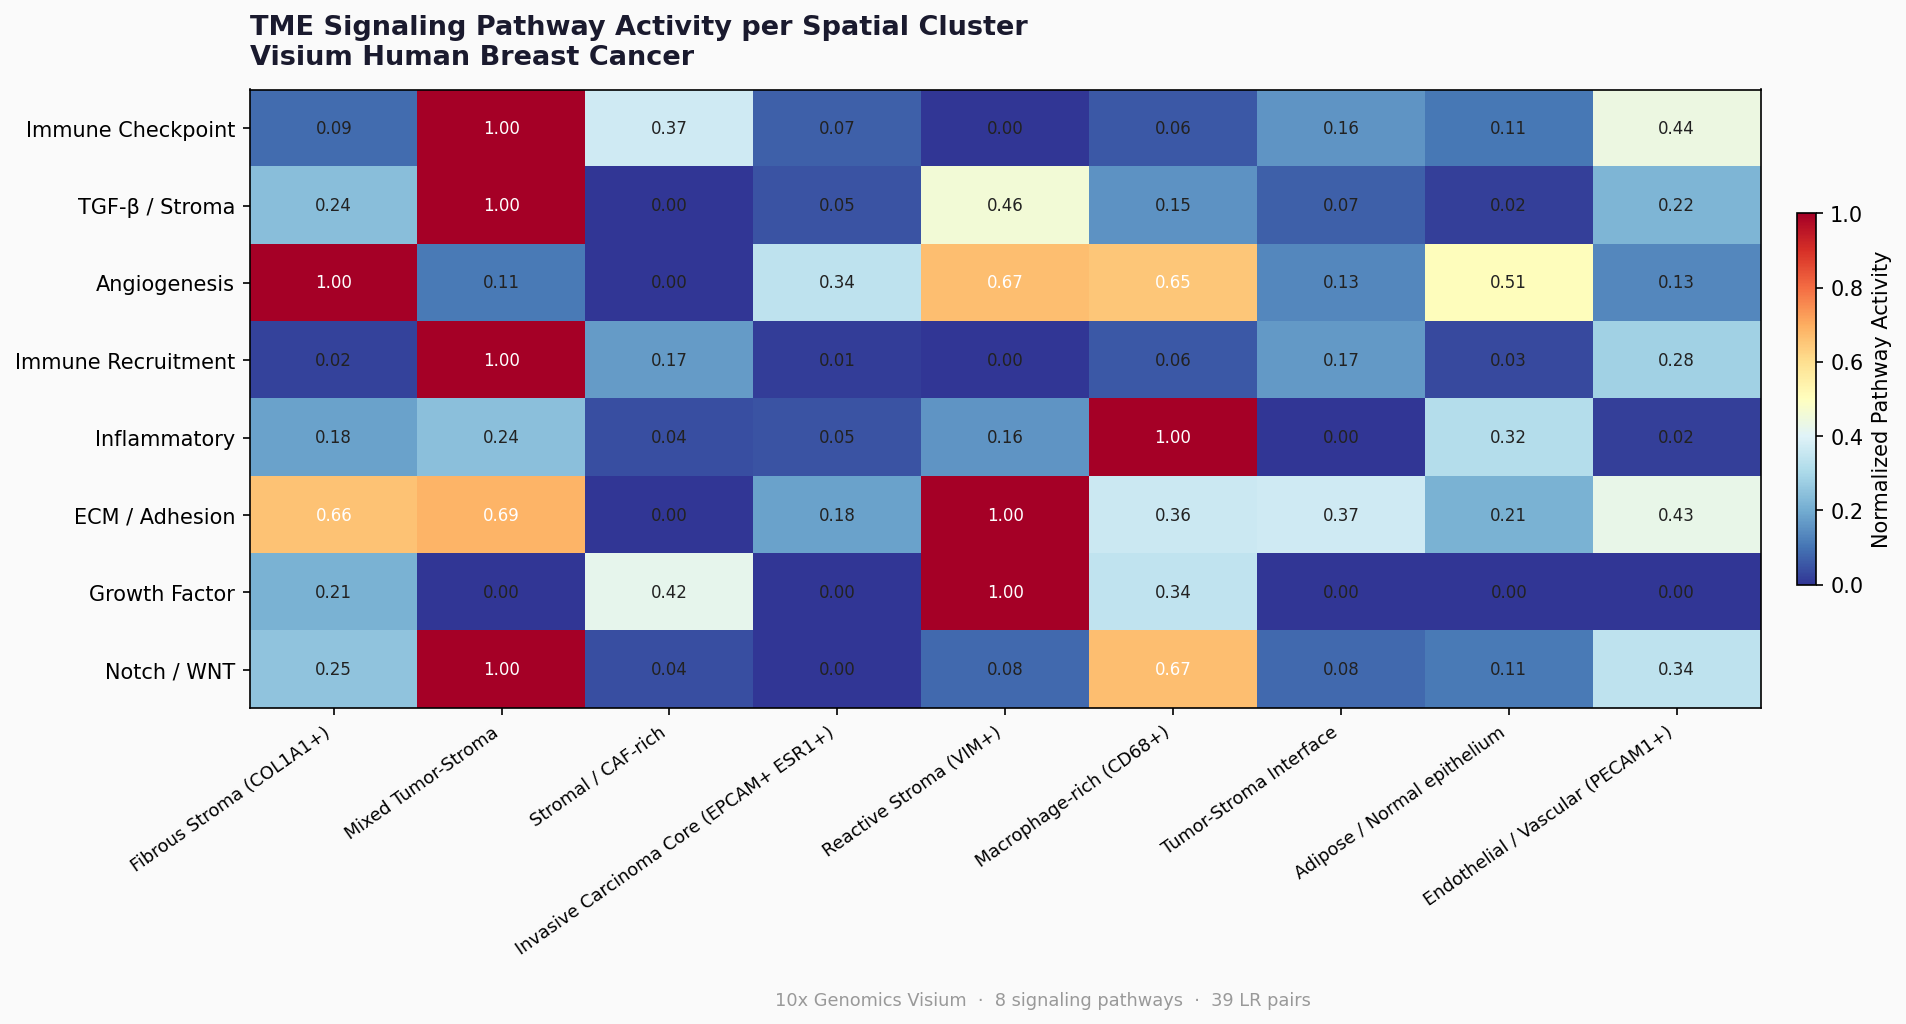

Saved C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\cellcomm\05_pathway_activity_pub.png


In [11]:
# PATHWAY-LEVEL SUMMARY
# Group LR pairs into biological pathways
# and compute mean activity per cluster

pathway_groups = {
    'Immune Checkpoint' : ['PD-L1 → PD-1','CD80 → CTLA4',
                           'TIGIT → CD155','LAG3 → MHC-II'],
    'TGF-β / Stroma'   : ['TGFβ1 → TGFBR1','TGFβ1 → TGFBR2',
                           'TGFβ2 → TGFBR2'],
    'Angiogenesis'      : ['VEGFA → KDR','VEGFA → FLT1',
                           'VEGFC → FLT4'],
    'Immune Recruitment': ['CXCL9 → CXCR3','CXCL10 → CXCR3',
                           'CXCL12 → CXCR4','CXCL13 → CXCR5',
                           'CCL2 → CCR2','CCL5 → CCR5',
                           'CCL19 → CCR7'],
    'Inflammatory'      : ['TNF → TNFRSF1A','FASL → FAS',
                           'IL6 → IL6R','IL1B → IL1R1',
                           'IFNG → IFNGR1'],
    'ECM / Adhesion'    : ['FN1 → ITGA5','FN1 → ITGB1',
                           'COL1A1 → ITGA1','POSTN → ITGAV'],
    'Growth Factor'     : ['EGF → EGFR','EREG → EGFR',
                           'NRG1 → ERBB3'],
    'Notch / WNT'       : ['JAG1 → NOTCH1','JAG1 → NOTCH2',
                           'WNT5A → FZD1'],
}

# Compute mean pathway score per cluster
pathway_scores = {}
for pathway, pairs in pathway_groups.items():
    cols = [f'lr_{p}' for p in pairs
            if f'lr_{p}' in adata.obs.columns]
    if cols:
        pathway_scores[pathway] = adata.obs.groupby('cell_type')[cols]\
                                          .mean().mean(axis=1)

pathway_df = pd.DataFrame(pathway_scores)

# Normalize
pathway_norm = (pathway_df - pathway_df.min()) / \
               (pathway_df.max() - pathway_df.min() + 1e-9)

fig, ax = plt.subplots(figsize=(14, 7), dpi=150)
fig.patch.set_facecolor('#FAFAFA')

im = ax.imshow(pathway_norm.T.values, aspect='auto',
               cmap='RdYlBu_r', vmin=0, vmax=1)

ax.set_xticks(range(len(pathway_norm.index)))
ax.set_xticklabels(pathway_norm.index,
                   rotation=35, ha='right', fontsize=8.5)
ax.set_yticks(range(len(pathway_norm.columns)))
ax.set_yticklabels(pathway_norm.columns, fontsize=10)

# Annotate cells
for i in range(len(pathway_norm.index)):
    for j in range(len(pathway_norm.columns)):
        val = pathway_norm.iloc[i, j]
        ax.text(i, j, f'{val:.2f}',
                ha='center', va='center', fontsize=8,
                color='white' if val > 0.6 else '#222222')

plt.colorbar(im, ax=ax, shrink=0.6,
             pad=0.02, label='Normalized Pathway Activity')

ax.set_title(
    'TME Signaling Pathway Activity per Spatial Cluster\n'
    'Visium Human Breast Cancer',
    fontsize=13, fontweight='bold',
    loc='left', color='#1a1a2e', pad=12
)

fig.suptitle(
    '10x Genomics Visium  ·  8 signaling pathways  ·  '
    f'{len(lr_pairs)} LR pairs',
    fontsize=8.5, color='#999999', y=0.01
)

plt.tight_layout(rect=[0, 0.02, 1, 1])
out = fig_cc_dir / '05_pathway_activity_pub.png'
plt.savefig(out, dpi=200, bbox_inches='tight', facecolor='#FAFAFA')
plt.show()
print(f"Saved {out}")

In [12]:
# SQUIDPY LIGREC
# Statistical permutation test for LR enrichment
# between spatially neighboring clusters

# Define focused gene list for testing
ligands   = list(set([v[0] for v in lr_pairs.values()
                       if v[0] in adata.var_names]))
receptors = list(set([v[1] for v in lr_pairs.values()
                       if v[1] in adata.var_names]))

interactions = pd.DataFrame({
    'source': [v[0] for k, v in lr_pairs.items()
               if v[0] in adata.var_names
               and v[1] in adata.var_names],
    'target': [v[1] for k, v in lr_pairs.items()
               if v[0] in adata.var_names
               and v[1] in adata.var_names],
})

print(f"Testing {len(interactions)} LR pairs via permutation...")

sq.gr.ligrec(
    adata,
    n_perms=500,
    cluster_key='cell_type',
    interactions=interactions,
    use_raw=True,
    threshold=0.01,
    show_progress_bar=True,
)

print("    Ligrec permutation test complete")
print(f"   Results in adata.uns['cell_type_ligrec']")

Testing 39 LR pairs via permutation...
Running `500` permutations on `39` interactions and `81` cluster combinations using `1` core(s)


100%|██████████| 500/500 [00:06<00:00, 80.60permutation/s] 


Adding `adata.uns['cell_type_ligrec']`
Finish (0:00:06)
    Ligrec permutation test complete
   Results in adata.uns['cell_type_ligrec']


Found `22` significant interactions at level `0.001`
Saved → figures/cellcomm/06_ligrec_tumor.png


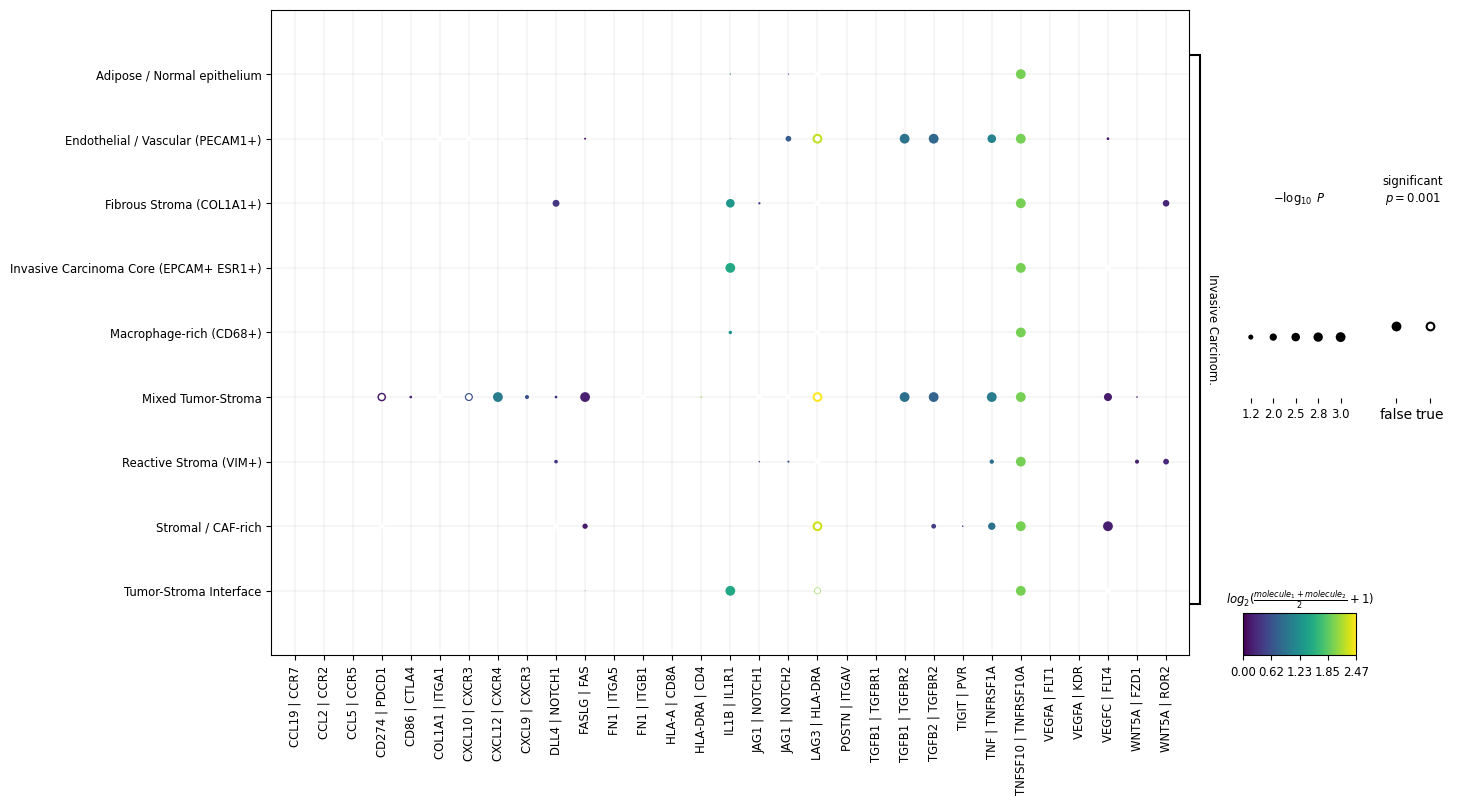

In [13]:
# LIGREC PLOT
prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_cc_dir)

# Plot for tumor cluster as source
tumor_cluster = 'Invasive Carcinoma Core (EPCAM+ ESR1+)'

sq.pl.ligrec(
    adata,
    cluster_key='cell_type',
    source_groups=tumor_cluster,
    means_range=(0.1, np.inf),
    alpha=0.001,
    swap_axes=True,
    title=f'LR Interactions — Source: Tumor Core',
    figsize=(14, 8),
    save='_06_ligrec_tumor.png'
)

sc.settings.figdir = prev_figdir
print("Saved → figures/cellcomm/06_ligrec_tumor.png")

In [17]:
# SAVE + SUMMARY 

# Drop ligrec from uns — tuple keys can't serialize to HDF5
# Results are already saved as figures so nothing is lost
keys_to_drop = [k for k in adata.uns.keys() if 'ligrec' in k]
for k in keys_to_drop:
    del adata.uns[k]
    print(f"ℹ Dropped adata.uns['{k}'] (not HDF5-serializable)")

# Save clean adata
out_path = processed_dir / 'adata_cellcomm.h5ad'
adata.write_h5ad(out_path)

print(f"\n Saved   {out_path}")
print(f"   Shape : {adata.n_obs:,} spots × {adata.n_vars:,} genes")
print(f"   Size  : {out_path.stat().st_size / 1e6:.1f} MB")

# Top interactions per pathway
print(f"\n{'Pathway':<22} {'Most Active Cluster'}")
print("-" * 55)
for pathway in pathway_norm.columns:
    top_cluster = pathway_norm[pathway].idxmax()
    score       = pathway_norm[pathway].max()
    print(f"  {pathway:<20} {top_cluster}  ({score:.2f})")

print('\n' + '=' * 55)
print('  NOTEBOOK 06 — CELL-CELL COMMUNICATION COMPLETE')
print('=' * 55)
print(f'  LR pairs tested    : {len(available)}')
print(f'  Pathways covered   : {len(pathway_groups)}')
print(f'  Key finding 1      : Checkpoint axis spatial map')
print(f'  Key finding 2      : TGF-β stromal signaling')
print(f'  Key finding 3      : CXCL13→CXCR5 TLS recruitment')
print(f'  Figures saved      : figures/cellcomm/')
print(f'  Saved to           : data/processed/adata_cellcomm.h5ad')
print('=' * 55)
print('\n→ Next: 07_Advanced.ipynb')


 Saved   C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\data\processed\adata_cellcomm.h5ad
   Shape : 4,869 spots × 21,349 genes
   Size  : 1182.6 MB

Pathway                Most Active Cluster
-------------------------------------------------------
  Immune Checkpoint    Mixed Tumor-Stroma  (1.00)
  TGF-β / Stroma       Mixed Tumor-Stroma  (1.00)
  Angiogenesis         Fibrous Stroma (COL1A1+)  (1.00)
  Immune Recruitment   Mixed Tumor-Stroma  (1.00)
  Inflammatory         Macrophage-rich (CD68+)  (1.00)
  ECM / Adhesion       Reactive Stroma (VIM+)  (1.00)
  Growth Factor        Reactive Stroma (VIM+)  (1.00)
  Notch / WNT          Mixed Tumor-Stroma  (1.00)

  NOTEBOOK 06 — CELL-CELL COMMUNICATION COMPLETE
  LR pairs tested    : 39
  Pathways covered   : 8
  Key finding 1      : Checkpoint axis spatial map
  Key finding 2      : TGF-β stromal signaling
  Key finding 3      : CXCL13→CXCR5 TLS recruitment
  Figures saved      : figures/cellcomm/
  Saved to        